In [1]:
!pip install --upgrade openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.1/212.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.9.0 which is incompatible.


In [2]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.


- 使用Amazon 568,454食物评价中的1000条作为Embedding的案例

In [3]:
# imports
import pandas as pd
import tiktoken

from openai import OpenAI
client = OpenAI(api_key="sk-")

# set text-Embedding modal default to text-embedding-ada-002
def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding


In [4]:
# embedding model parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8196

In [5]:
# load & inspect dataset
input_datapath = "fine_food_reviews_1k.csv"  # to save space, we provide a pre-filtered dataset
df = pd.read_csv(input_datapath, index_col=0)
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
df = df.dropna()
df["combined"] = (
    "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)
df.head(2)

,Time,ProductId,UserId,Score,Summary,Text,combined
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...


In [6]:
# subsample to 1k most recent reviews and remove samples that are too long
top_n = 1000
df = df.sort_values("Time").tail(top_n * 2)  # first cut to first 2k entries, assuming less than half will be filtered out
df.drop("Time", axis=1, inplace=True)

encoding = tiktoken.get_encoding(embedding_encoding)

# omit reviews that are too long to embed, make sure the there will be no runtime error
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens].tail(top_n)
len(df)

1000

In [7]:
# Ensure you have your API key set in your environment per the README: https://github.com/openai/openai-python#usage

# This may take a few minutes
df["embedding"] = df.combined.apply(lambda x: get_embedding(x, model=embedding_model))
df.to_csv("fine_food_reviews_with_embeddings_1k.csv")

- 将高维的text Embedding进行低维度展示

In [8]:
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
from ast import literal_eval

# Load the embeddings
datafile_path = "fine_food_reviews_with_embeddings_1k.csv"
df = pd.read_csv(datafile_path)

# Convert to a list of lists of floats
matrix = np.array(df.embedding.apply(literal_eval).to_list())

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

(1000, 2)

Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

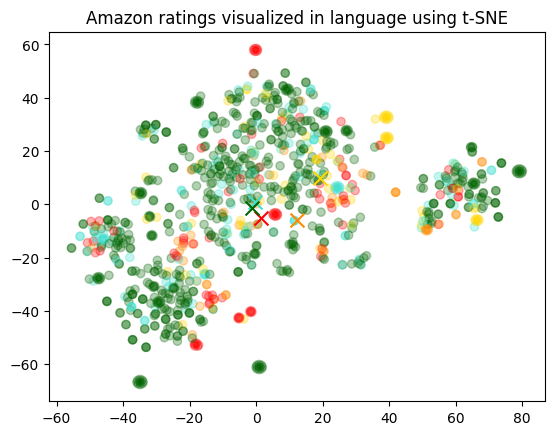

In [9]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
color_indices = df.Score.values - 1

colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
# plot average score for every score cluster
for score in [0,1,2,3,4]:
    avg_x = np.array(x)[df.Score-1==score].mean()
    avg_y = np.array(y)[df.Score-1==score].mean()
    color = colors[score]
    plt.scatter(avg_x, avg_y, marker='x', color=color, s=100)

plt.title("Amazon ratings visualized in language using t-SNE")

- 将Embedding之后的text进行聚类

In [10]:
df["embedding"] = df.embedding.apply(literal_eval).apply(np.array)  # convert string to numpy array
matrix = np.vstack(df.embedding.values)
matrix.shape # 当前的Embedding维度

(1000, 1536)

In [11]:
from sklearn.cluster import KMeans

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

df.groupby("Cluster").Score.mean().sort_values()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster
1    4.037175
3    4.191176
0    4.215613
2    4.377301
Name: Score, dtype: float64

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

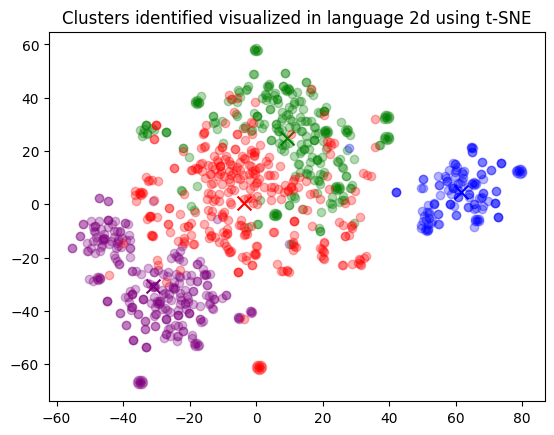

In [12]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


In [13]:
import openai

# Reading a review which belong to each group.
rev_per_cluster = 5 # 定义了每个簇（主题/分类）要处理的评论数为5条

for i in range(n_clusters):
    # 打印当前的簇编号和“Theme:"字样，`end=" "`指定末尾不换行，而是空格。
    print(f"Cluster {i} Theme:", end=" ")

    # 处理字符串，并将其合并成一个由新行符分隔的长字符串`reviews`
    reviews = "\n".join(
        df[df.Cluster == i]
        .combined.str.replace("Title: ", "")
        .str.replace("\n\nContent: ", ":  ")
        .sample(rev_per_cluster, random_state=42)
        .values
    )
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
          {"role": "system", "content": "You are a helpful assistant designed to output JSON."},
          {"role": "user", "content": f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews}\n"""\n\nTheme:'}
        ],
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response.choices[0].message.content + '\n')

    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.Score.values[j], end=", ")
        print(sample_cluster_rows.Summary.values[j], end=":   ")
        print(sample_cluster_rows.Text.str[:70].values[j])

    print("-" * 100)


Cluster 0 Theme: The common theme among these customer reviews is that they are all discussing different types of coffee and expressing their opinions about the taste, quality, and availability of the coffee.

5, Fog Chaser Coffee:   This coffee has a full body and a rich taste. The price is far below t
5, Excellent taste:   This is to me a great coffee, once you try it you will enjoy it, this 
4, Good, but not Wolfgang Puck good:   Honestly, I have to admit that I expected a little better. That's not 
5, Just My Kind of Coffee:   Coffee Masters Hazelnut coffee used to be carried in a local coffee/pa
5, Rodeo Drive is Crazy Good Coffee!:   Rodeo Drive is my absolute favorite and I'm ready to order more!  That
----------------------------------------------------------------------------------------------------
Cluster 1 Theme: The common theme among these customer reviews is that they all express positive opinions about the products mentioned.

5, Makes me drool just thinking of them:   

- 基于已有数据训练一个回归模型，预测评论的得分

In [14]:
import pandas as pd
import numpy as np
from ast import literal_eval

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

datafile_path = "fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(literal_eval).apply(np.array)

X_train, X_test, y_train, y_test = train_test_split(list(df.embedding.values), df.Score, test_size=0.2, random_state=42)

rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, y_train)
preds = rfr.predict(X_test)

mse = mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)

print(f"ada-002 embedding performance on 1k Amazon reviews: mse={mse:.2f}, mae={mae:.2f}")


ada-002 embedding performance on 1k Amazon reviews: mse=0.62, mae=0.53


In [15]:
bmse = mean_squared_error(y_test, np.repeat(y_test.mean(), len(y_test)))
bmae = mean_absolute_error(y_test, np.repeat(y_test.mean(), len(y_test)))
print(
    f"Dummy mean prediction performance on Amazon reviews: mse={bmse:.2f}, mae={bmae:.2f}"
)


Dummy mean prediction performance on Amazon reviews: mse=1.73, mae=1.03


- 使用Classification对文本进行训练分类能力

In [16]:
# imports
import pandas as pd
import numpy as np
from ast import literal_eval

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# load data
datafile_path = "fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(literal_eval).apply(np.array)  # convert string to array

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    list(df.embedding.values), df.Score, test_size=0.2, random_state=42
)

# train random forest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)

report = classification_report(y_test, preds)
print(report)


              precision    recall  f1-score   support

           1       0.86      0.30      0.44        20
           2       1.00      0.38      0.55         8
           3       1.00      0.18      0.31        11
           4       1.00      0.26      0.41        27
           5       0.74      1.00      0.85       134

    accuracy                           0.76       200
   macro avg       0.92      0.42      0.51       200
weighted avg       0.81      0.76      0.71       200



In [17]:
from sklearn.metrics import average_precision_score, precision_recall_curve
def plot_multiclass_precision_recall(
    y_score, y_true_untransformed, class_list, classifier_name
):
    """
    Precision-Recall plotting for a multiclass problem. It plots average precision-recall, per class precision recall and reference f1 contours.

    Code slightly modified, but heavily based on https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
    """
    n_classes = len(class_list)
    y_true = pd.concat(
        [(y_true_untransformed == class_list[i]) for i in range(n_classes)], axis=1
    ).values

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_true[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision_micro, recall_micro, _ = precision_recall_curve(
        y_true.ravel(), y_score.ravel()
    )
    average_precision_micro = average_precision_score(y_true, y_score, average="micro")
    print(
        str(classifier_name)
        + " - Average precision score over all classes: {0:0.2f}".format(
            average_precision_micro
        )
    )

    # setup plot details
    plt.figure(figsize=(9, 10))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append("iso-f1 curves")
    (l,) = plt.plot(recall_micro, precision_micro, color="gold", lw=2)
    lines.append(l)
    labels.append(
        "average Precision-recall (auprc = {0:0.2f})" "".format(average_precision_micro)
    )

    for i in range(n_classes):
        (l,) = plt.plot(recall[i], precision[i], lw=2)
        lines.append(l)
        labels.append(
            "Precision-recall for class `{0}` (auprc = {1:0.2f})"
            "".format(class_list[i], average_precision[i])
        )

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{classifier_name}: Precision-Recall curve for each class")
    plt.legend(lines, labels)

RandomForestClassifier() - Average precision score over all classes: 0.88


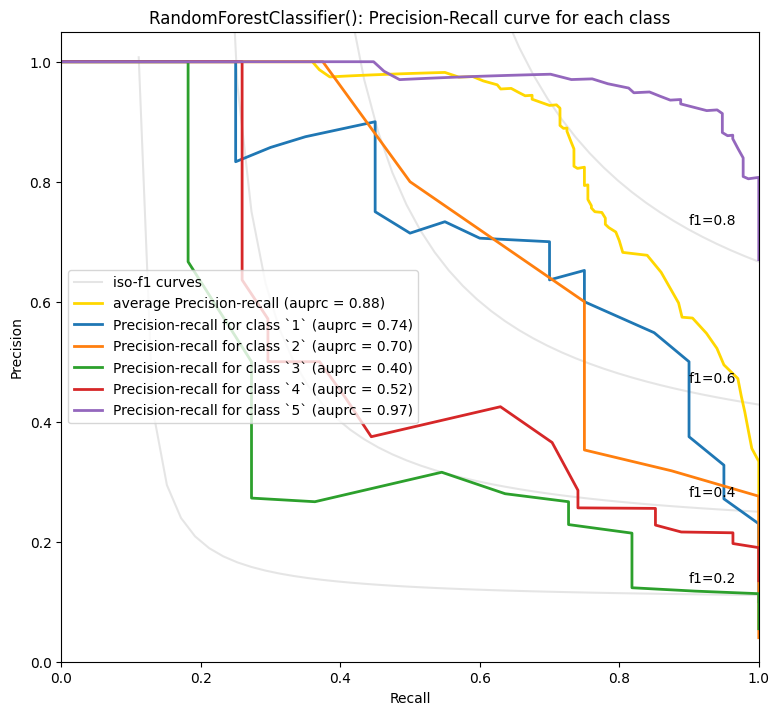

In [18]:
plot_multiclass_precision_recall(probas, y_test, [1, 2, 3, 4, 5], clf)

- 基于文本语义的搜索

In [19]:
datafile_path = "fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(literal_eval).apply(np.array)

In [20]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# search through the reviews for a specific product
def search_reviews(df, product_description, n=3, pprint=True):
    product_embedding = get_embedding(
        product_description,
        model="text-embedding-ada-002"
    )
    df["similarity"] = df.embedding.apply(lambda x: cosine_similarity(x, product_embedding))

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .combined.str.replace("Title: ", "")
        .str.replace("; Content:", ": ")
    )
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results


results = search_reviews(df, "delicious beans", n=3)


Good Buy:  I liked the beans. They were vacuum sealed, plump and moist. Would recommend them for any use. I personally split and stuck them in some vodka to make vanilla extract. Yum!

Jamaican Blue beans:  Excellent coffee bean for roasting. Our family just purchased another 5 pounds for more roasting. Plenty of flavor and mild on acidity when roasted to a dark brown bean and befor

Delicious!:  I enjoy this white beans seasoning, it gives a rich flavor to the beans I just love it, my mother in law didn't know about this Zatarain's brand and now she is traying different seasoning



In [21]:
results = search_reviews(df, "whole wheat pasta", n=3)

Tasty and Quick Pasta:  Barilla Whole Grain Fusilli with Vegetable Marinara is tasty and has an excellent chunky vegetable marinara.  I just wish there was more of it.  If you aren't starving or on a 

sooo good:  tastes so good. Worth the money. My boyfriend hates wheat pasta and LOVES this. cooks fast tastes great.I love this brand and started buying more of their pastas. Bulk is best.

Handy:  Love the idea of ready in a minute pasta and for that alone this product gets praise.  The pasta is whole grain so that's a big plus and it actually comes out al dente.  The vegetable marinara



In [22]:
results = search_reviews(df, "bad delivery", n=2)


great product, poor delivery:  The coffee is excellent and I am a repeat buyer.  Problem this time was with the UPS delivery.  They left the box in front of my garage door in the middle of the drivewa

great product, poor delivery:  The coffee is excellent and I am a repeat buyer.  Problem this time was with the UPS delivery.  They left the box in front of my garage door in the middle of the drivewa



In [23]:
results = search_reviews(df, "pet food", n=2)


Good food:  The only dry food my queen cat will eat. Helps prevent hair balls. Good packaging. Arrives promptly. Recommended by a friend who sells pet food.

The cats like it:  My 7 cats like this food but it is a little yucky for the human. Pieces of mackerel swimming in a dark broth. It is billed as a "complete" food and contains carrots, peas and pasta.



- 使用嵌入和最近邻搜索的推荐场景应用

In [24]:
import pandas as pd
import pickle
from scipy import spatial
import textwrap as tr
import numpy as np
import plotly.express as px
from sklearn.manifold import TSNE
from typing import List, Optional


def get_embedding(text: str, model="text-similarity-davinci-001", **kwargs) -> List[float]:

    # replace newlines, which can negatively affect performance.
    text = text.replace("\n", " ")

    response = openai.embeddings.create(input=[text], model=model, **kwargs)

    return response.data[0].embedding


def distances_from_embeddings(
    query_embedding: List[float],
    embeddings: List[List[float]],
    distance_metric="cosine",
) -> List[List]:
    """Return the distances between a query embedding and a list of embeddings."""
    distance_metrics = {
        "cosine": spatial.distance.cosine,
        "L1": spatial.distance.cityblock,
        "L2": spatial.distance.euclidean,
        "Linf": spatial.distance.chebyshev,
    }
    distances = [
        distance_metrics[distance_metric](query_embedding, embedding)
        for embedding in embeddings
    ]
    return distances

def tsne_components_from_embeddings(
    embeddings: List[List[float]], n_components=2, **kwargs
) -> np.ndarray:
    """Returns t-SNE components of a list of embeddings."""
    # use better defaults if not specified
    if "init" not in kwargs.keys():
        kwargs["init"] = "pca"
    if "learning_rate" not in kwargs.keys():
        kwargs["learning_rate"] = "auto"
    tsne = TSNE(n_components=n_components, **kwargs)
    array_of_embeddings = np.array(embeddings)
    return tsne.fit_transform(array_of_embeddings)

def chart_from_components(
    components: np.ndarray,
    labels: Optional[List[str]] = None,
    strings: Optional[List[str]] = None,
    x_title="Component 0",
    y_title="Component 1",
    mark_size=5,
    **kwargs,
):
    """Return an interactive 2D chart of embedding components."""
    empty_list = ["" for _ in components]
    data = pd.DataFrame(
        {
            x_title: components[:, 0],
            y_title: components[:, 1],
            "label": labels if labels else empty_list,
            "string": ["<br>".join(tr.wrap(string, width=30)) for string in strings]
            if strings
            else empty_list,
        }
    )
    chart = px.scatter(
        data,
        x=x_title,
        y=y_title,
        color="label" if labels else None,
        symbol="label" if labels else None,
        hover_data=["string"] if strings else None,
        **kwargs,
    ).update_traces(marker=dict(size=mark_size))
    return chart

def indices_of_nearest_neighbors_from_distances(distances) -> np.ndarray:
    """Return a list of indices of nearest neighbors from a list of distances."""
    return np.argsort(distances)

In [25]:
# load data (full dataset available at http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html)
dataset_path = "AG_news_samples.csv"
df = pd.read_csv(dataset_path)

# print dataframe
n_examples = 5
df.head(n_examples)


,title,description,label_int,label
0,World Briefings,BRITAIN: BLAIR WARNS OF CLIMATE THREAT Prime M...,1,World
1,Nvidia Puts a Firewall on a Motherboard (PC Wo...,PC World - Upcoming chip set will include buil...,4,Sci/Tech
2,"Olympic joy in Greek, Chinese press",Newspapers in Greece reflect a mixture of exhi...,2,Sports
3,U2 Can iPod with Pictures,"SAN JOSE, Calif. -- Apple Computer (Quote, Cha...",4,Sci/Tech
4,The Dream Factory,"Any product, any shape, any size -- manufactur...",4,Sci/Tech


In [26]:
# print the title, description, and label of each example
for idx, row in df.head(n_examples).iterrows():
    print("")
    print(f"Title: {row['title']}")
    print(f"Description: {row['description']}")
    print(f"Label: {row['label']}")


Title: World Briefings
Description: BRITAIN: BLAIR WARNS OF CLIMATE THREAT Prime Minister Tony Blair urged the international community to consider global warming a dire threat and agree on a plan of action to curb the  quot;alarming quot; growth of greenhouse gases.
Label: World

Title: Nvidia Puts a Firewall on a Motherboard (PC World)
Description: PC World - Upcoming chip set will include built-in security features for your PC.
Label: Sci/Tech

Title: Olympic joy in Greek, Chinese press
Description: Newspapers in Greece reflect a mixture of exhilaration that the Athens Olympics proved successful, and relief that they passed off without any major setback.
Label: Sports

Title: U2 Can iPod with Pictures
Description: SAN JOSE, Calif. -- Apple Computer (Quote, Chart) unveiled a batch of new iPods, iTunes software and promos designed to keep it atop the heap of digital music players.
Label: Sci/Tech

Title: The Dream Factory
Description: Any product, any shape, any size -- manufactured o

In [28]:
# constants
EMBEDDING_MODEL = "text-embedding-ada-002"
# establish a cache of embeddings to avoid recomputing
# cache is a dict of tuples (text, model) -> embedding, saved as a pickle file

# set path to embedding cache
embedding_cache_path = "recommendations_embeddings_cache.pkl"

# load the cache if it exists, and save a copy to disk
try:
    embedding_cache = pd.read_pickle(embedding_cache_path)
except FileNotFoundError:
    embedding_cache = {}
with open(embedding_cache_path, "wb") as embedding_cache_file:
    pickle.dump(embedding_cache, embedding_cache_file)

# define a function to retrieve embeddings from the cache if present, and otherwise request via the API
def embedding_from_string(
    string: str,
    model: str = EMBEDDING_MODEL,
    embedding_cache=embedding_cache
) -> list:
    """Return embedding of given string, using a cache to avoid recomputing."""
    if (string, model) not in embedding_cache.keys():
        embedding_cache[(string, model)] = get_embedding(string, model)
        with open(embedding_cache_path, "wb") as embedding_cache_file:
            pickle.dump(embedding_cache, embedding_cache_file)
    return embedding_cache[(string, model)]


In [34]:
import os

os.environ["OPENAI_API_KEY" ]= "sk-"

In [35]:
# as an example, take the first description from the dataset
example_string = df["description"].values[0]
print(f"\nExample string: {example_string}")

# print the first 10 dimensions of the embedding
example_embedding = embedding_from_string(example_string)
print(f"\nExample embedding: {example_embedding[:10]}...")



Example string: BRITAIN: BLAIR WARNS OF CLIMATE THREAT Prime Minister Tony Blair urged the international community to consider global warming a dire threat and agree on a plan of action to curb the  quot;alarming quot; growth of greenhouse gases.

Example embedding: [-0.010669779032468796, -0.02238333970308304, -0.008827051147818565, -0.02538582682609558, 0.03136502578854561, 0.010766425170004368, -0.01677783951163292, 0.004291106481105089, -0.007989447563886642, -0.02144264616072178]...


In [36]:
def print_recommendations_from_strings(
    strings: list[str],
    index_of_source_string: int,
    k_nearest_neighbors: int = 1,
    model=EMBEDDING_MODEL,
) -> list[int]:
    """Print out the k nearest neighbors of a given string."""
    # get embeddings for all strings
    embeddings = [embedding_from_string(string, model=model) for string in strings]
    # get the embedding of the source string
    query_embedding = embeddings[index_of_source_string]
    # get distances between the source embedding and other embeddings (function from utils.embeddings_utils.py)
    distances = distances_from_embeddings(query_embedding, embeddings, distance_metric="cosine")
    # get indices of nearest neighbors (function from utils.utils.embeddings_utils.py)
    indices_of_nearest_neighbors = indices_of_nearest_neighbors_from_distances(distances)

    # print out source string
    query_string = strings[index_of_source_string]
    print(f"Source string: {query_string}")
    # print out its k nearest neighbors
    k_counter = 0
    for i in indices_of_nearest_neighbors:
        # skip any strings that are identical matches to the starting string
        if query_string == strings[i]:
            continue
        # stop after printing out k articles
        if k_counter >= k_nearest_neighbors:
            break
        k_counter += 1

        # print out the similar strings and their distances
        print(
            f"""
        --- Recommendation #{k_counter} (nearest neighbor {k_counter} of {k_nearest_neighbors}) ---
        String: {strings[i]}
        Distance: {distances[i]:0.3f}"""
        )

    return indices_of_nearest_neighbors


In [37]:
article_descriptions = df["description"].tolist()

tony_blair_articles = print_recommendations_from_strings(
    strings=article_descriptions,  # let's base similarity off of the article description
    index_of_source_string=0,  # let's look at articles similar to the first one about Tony Blair
    k_nearest_neighbors=5,  # let's look at the 5 most similar articles
)


Source string: BRITAIN: BLAIR WARNS OF CLIMATE THREAT Prime Minister Tony Blair urged the international community to consider global warming a dire threat and agree on a plan of action to curb the  quot;alarming quot; growth of greenhouse gases.

        --- Recommendation #1 (nearest neighbor 1 of 5) ---
        String: THE re-election of British Prime Minister Tony Blair would be seen as an endorsement of the military action in Iraq, Prime Minister John Howard said today.
        Distance: 0.153

        --- Recommendation #2 (nearest neighbor 2 of 5) ---
        String: LONDON, England -- A US scientist is reported to have observed a surprising jump in the amount of carbon dioxide, the main greenhouse gas.
        Distance: 0.160

        --- Recommendation #3 (nearest neighbor 3 of 5) ---
        String: The anguish of hostage Kenneth Bigley in Iraq hangs over Prime Minister Tony Blair today as he faces the twin test of a local election and a debate by his Labour Party about the di

In [38]:
chipset_security_articles = print_recommendations_from_strings(
    strings=article_descriptions,  # let's base similarity off of the article description
    index_of_source_string=1,  # let's look at articles similar to the second one about a more secure chipset
    k_nearest_neighbors=5,  # let's look at the 5 most similar articles
)

Source string: PC World - Upcoming chip set will include built-in security features for your PC.

        --- Recommendation #1 (nearest neighbor 1 of 5) ---
        String: PC World - Updated antivirus software for businesses adds intrusion prevention features.
        Distance: 0.112

        --- Recommendation #2 (nearest neighbor 2 of 5) ---
        String: PC World - The one-time World Class Product of the Year PDA gets a much-needed upgrade.
        Distance: 0.145

        --- Recommendation #3 (nearest neighbor 3 of 5) ---
        String: PC World - Send your video throughout your house--wirelessly--with new gateways and media adapters.
        Distance: 0.152

        --- Recommendation #4 (nearest neighbor 4 of 5) ---
        String: PC World - Symantec, McAfee hope raising virus-definition fees will move users to\  suites.
        Distance: 0.157

        --- Recommendation #5 (nearest neighbor 5 of 5) ---
        String: Gateway computers will be more widely available at Of

In [39]:
# get embeddings for all article descriptions
embeddings = [embedding_from_string(string) for string in article_descriptions]
# compress the 2048-dimensional embeddings into 2 dimensions using t-SNE
tsne_components = tsne_components_from_embeddings(embeddings)
# get the article labels for coloring the chart
labels = df["label"].tolist()

chart_from_components(
    components=tsne_components,
    labels=labels,
    strings=article_descriptions,
    width=600,
    height=500,
    title="t-SNE components of article descriptions",
)


In [40]:
# create labels for the recommended articles
def nearest_neighbor_labels(
    list_of_indices: list[int],
    k_nearest_neighbors: int = 5
) -> list[str]:
    """Return a list of labels to color the k nearest neighbors."""
    labels = ["Other" for _ in list_of_indices]
    source_index = list_of_indices[0]
    labels[source_index] = "Source"
    for i in range(k_nearest_neighbors):
        nearest_neighbor_index = list_of_indices[i + 1]
        labels[nearest_neighbor_index] = f"Nearest neighbor (top {k_nearest_neighbors})"
    return labels


tony_blair_labels = nearest_neighbor_labels(tony_blair_articles, k_nearest_neighbors=5)
chipset_security_labels = nearest_neighbor_labels(chipset_security_articles, k_nearest_neighbors=5
)


In [41]:
# a 2D chart of nearest neighbors of the Tony Blair article
chart_from_components(
    components=tsne_components,
    labels=tony_blair_labels,
    strings=article_descriptions,
    width=600,
    height=500,
    title="Nearest neighbors of the Tony Blair article",
    category_orders={"label": ["Other", "Nearest neighbor (top 5)", "Source"]},
)

In [42]:
# a 2D chart of nearest neighbors of the chipset security article
chart_from_components(
    components=tsne_components,
    labels=chipset_security_labels,
    strings=article_descriptions,
    width=600,
    height=500,
    title="Nearest neighbors of the chipset security article",
    category_orders={"label": ["Other", "Nearest neighbor (top 5)", "Source"]},
)
